<a href="https://colab.research.google.com/github/ajagadeesh45/crack_segmentation_model_in_buildings_and_roads/blob/main/Crack_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()


Saving crack segmentation.v3i.coco-segmentation.zip to crack segmentation.v3i.coco-segmentation.zip


In [ ]:
import zipfile
import os

zip_path = "/content/crack segmentation.v3i.coco-segmentation.zip"
extract_dir = "/content/crack_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(" Dataset extracted to:", extract_dir)


 Dataset extracted to: /content/crack_dataset


In [ ]:
!pip install pycocotools


In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import numpy as np
import cv2
from PIL import Image
import os

annotation_file = os.path.join(extract_dir, "train", "_annotations.coco.json")
image_folder = os.path.join(extract_dir, "train", "images")
output_mask_folder = os.path.join(extract_dir, "train", "masks")
os.makedirs(output_mask_folder, exist_ok=True)

coco = COCO(annotation_file)

image_ids = coco.getImgIds()

for img_id in image_ids:
    img_info = coco.loadImgs(img_id)[0]
    file_name = img_info['file_name']
    width = img_info['width']
    height = img_info['height']

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((height, width), dtype=np.uint8)
    for ann in anns:
        m = coco.annToMask(ann)
        mask = np.maximum(mask, m)


    mask_path = os.path.join(output_mask_folder, os.path.splitext(file_name)[0] + ".png")
    cv2.imwrite(mask_path, mask * 255)

print(" Masks generated and saved to:", output_mask_folder)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
 Masks generated and saved to: /content/crack_dataset/train/masks


In [ ]:
import os

base_dir = "/content"
print("Contents of base directory:", os.listdir(base_dir))


Contents of base directory: ['.config', 'crack_dataset', 'crack segmentation.v3i.coco-segmentation.zip', 'sample_data']


In [ ]:
for root, dirs, files in os.walk(extract_dir):
    print( root)


/content/crack_dataset
/content/crack_dataset/valid
/content/crack_dataset/train
/content/crack_dataset/train/masks
/content/crack_dataset/test


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 128, 128
image_dir = "/content/crack_dataset/train"
mask_dir = "/content/crack_dataset/train/masks"

X, Y = [], []

image_files = sorted(os.listdir(image_dir))

for file in image_files:
    img_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, os.path.splitext(file)[0] + ".png")

    if not os.path.exists(mask_path):
        continue


    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X.append(img)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)
    mask = (mask > 127).astype(np.uint8)
    Y.append(mask)

X = np.array(X)
Y = np.array(Y)

print(" Loaded images:", X.shape)
print(" Loaded masks :", Y.shape)


 Loaded images: (230, 128, 128, 3)
 Loaded masks : (230, 128, 128, 1)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(" Training set:", X_train.shape)
print(" Validation set:", X_val.shape)


 Training set: (184, 128, 128, 3)
 Validation set: (46, 128, 128, 3)


# U - NET MODEL

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape):
    inputs = Input(input_shape)


    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)


    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)


    u1 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = Conv2DTranspose(16, 2, strides=2, padding='same')(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │      2,064 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      4,624 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=4,
    epochs=50
)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 419ms/step - accuracy: 0.9744 - loss: 0.0883 - val_accuracy: 0.9577 - val_loss: 0.1904
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.9787 - loss: 0.0707 - val_accuracy: 0.9585 - val_loss: 0.1657
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 394ms/step - accuracy: 0.9742 - loss: 0.0887 - val_accuracy: 0.9587 - val_loss: 0.1754
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 434ms/step - accuracy: 0.9780 - loss: 0.0758 - val_accuracy: 0.9592 - val_loss: 0.1834
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.9760 - loss: 0.0802 - val_accuracy: 0.9582 - val_loss: 0.2032
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - accuracy: 0.9782 - loss: 0.0722 - val_accuracy: 0.9596 - val_loss: 0.1746
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 387ms/step - accuracy: 0.9788 - loss: 0.0694 - val_accuracy: 0.9588 - val_loss: 0.1619
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 413ms/step - accuracy: 0.9747 - loss: 0.0808 - val_accu

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


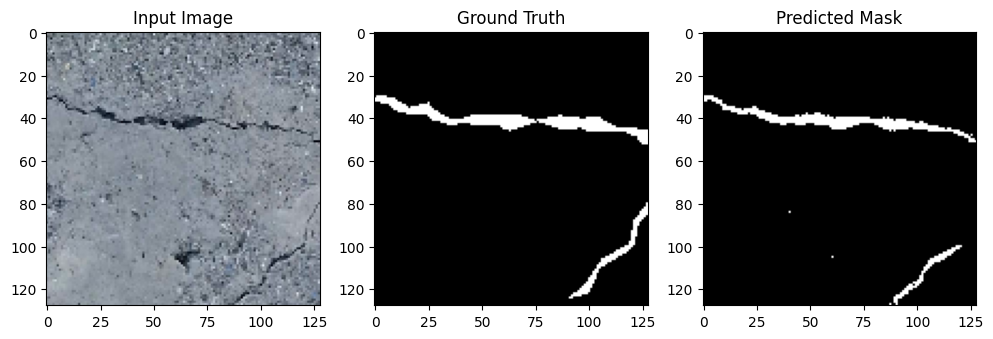

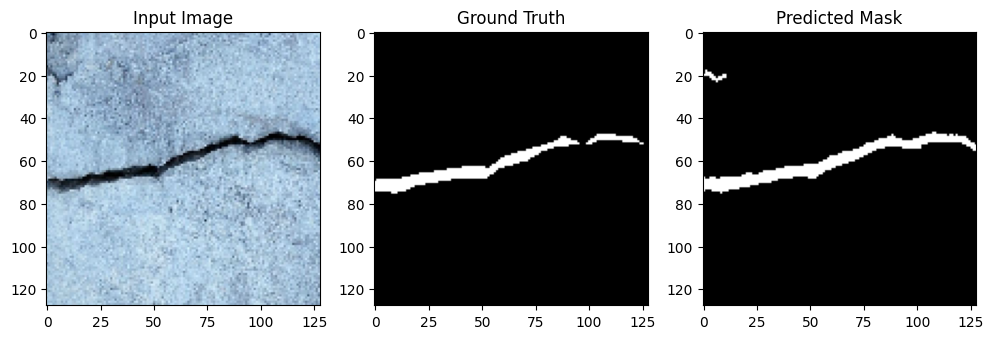

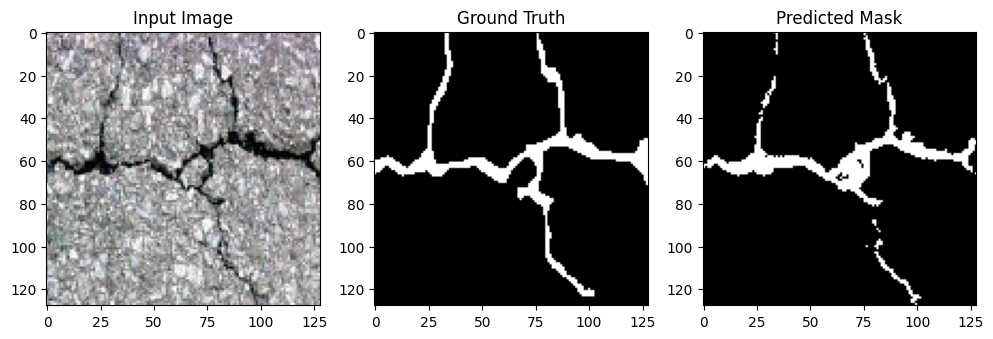

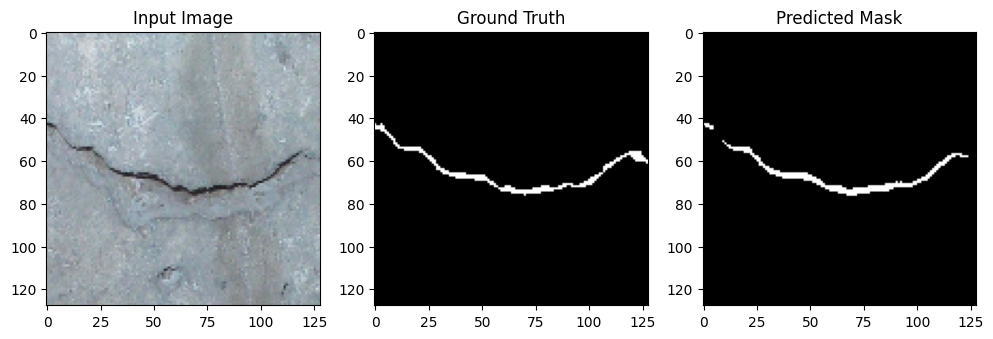

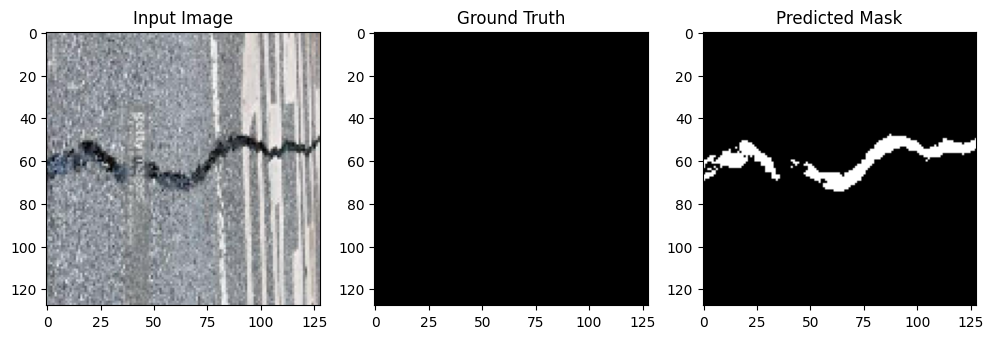

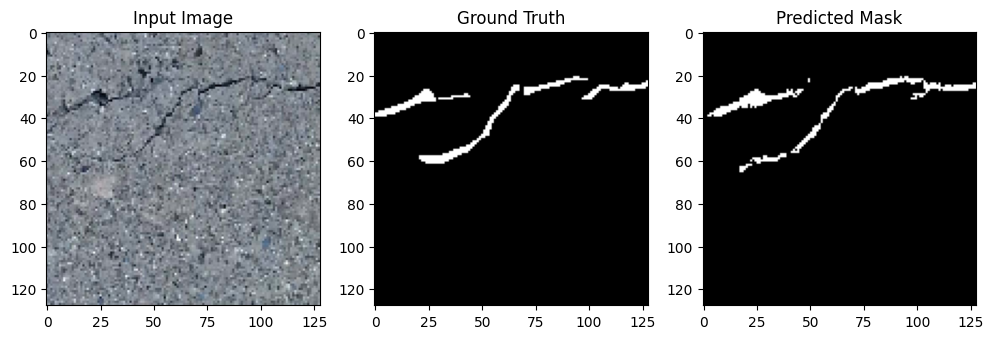

In [ ]:
import matplotlib.pyplot as plt

preds = model.predict(X_val)

for i in range(6):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(X_val[i])
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()
